# **IMPORTS**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

# **Loading the ASL dataset**

In [ ]:
train_df=pd.read_csv('/content/sign_mnist_train.csv')
test_df=pd.read_csv('/content/sign_mnist_test.csv')

test= pd.read_csv('/content/sign_mnist_test.csv')
y=test['label']

In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


# **Data Visualization and Preprocessing**

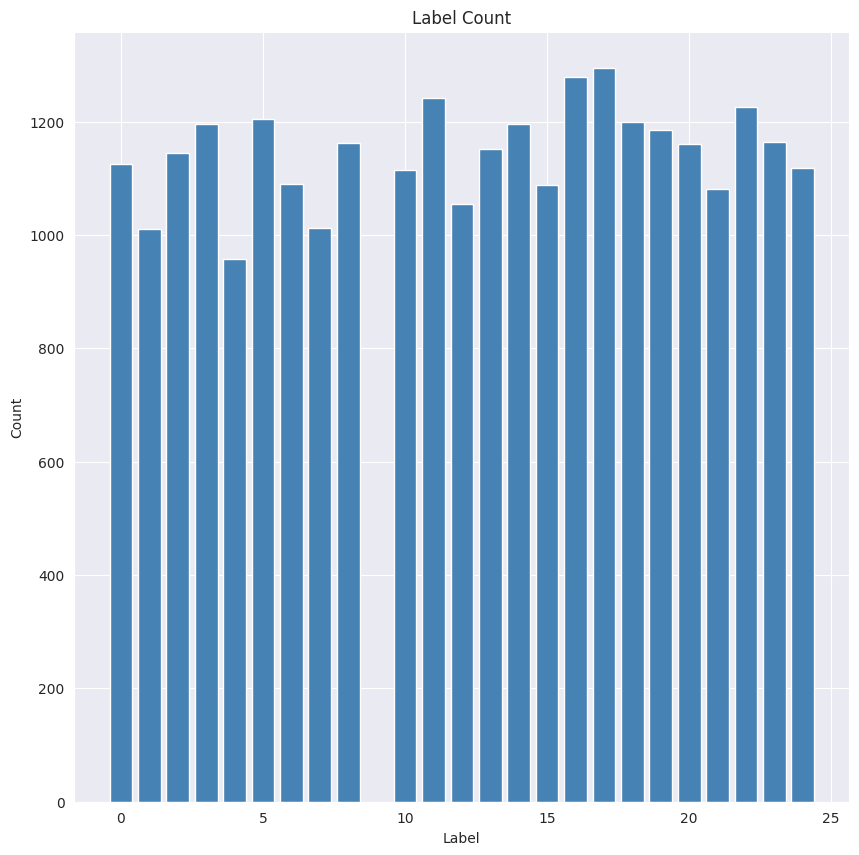

In [ ]:
label_counts = train_df['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 10))
plt.bar(label_counts.index, label_counts.values, color='steelblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Count')
plt.grid(True)
plt.show()

In [ ]:
y_train= train_df['label']
y_test= test_df['label']

del train_df['label']
del test_df['label']


In [ ]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [ ]:
x_train= train_df.values
x_test= test_df.values

# np.prod(X_train.shape)
# np.prod(X_test.shape)

# print(x_test[0])

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [ ]:
x_train=x_train/255.0
x_test=x_test/255.0
# print(x_test[0])

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

# **Preview of first 10 images**

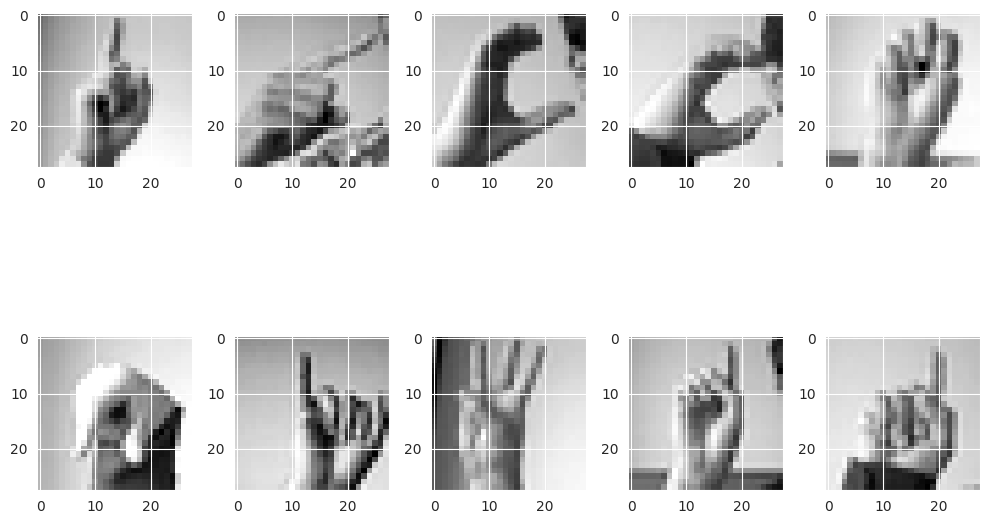

In [ ]:
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

# **Data Augmentation**
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)




In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)


In [ ]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_3 (Bat  (None, 28, 28, 75)        300       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 75)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 14, 14, 50)       

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 ,
                    validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])
model.save('sign-lang.h5')

Epoch 1/20
215/215 [==============================] - 116s 507ms/step - loss: 1.0604 - accuracy: 0.6672 - val_loss: 3.3242 - val_accuracy: 0.1028 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 110s 510ms/step - loss: 0.2103 - accuracy: 0.9320 - val_loss: 1.2062 - val_accuracy: 0.5707 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 106s 491ms/step - loss: 0.1023 - accuracy: 0.9681 - val_loss: 0.1899 - val_accuracy: 0.9410 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 106s 492ms/step - loss: 0.0621 - accuracy: 0.9816 - val_loss: 0.0366 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 105s 490ms/step - loss: 0.0494 - accuracy: 0.9839 - val_loss: 0.1064 - val_accuracy: 0.9598 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9889
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")


225/225 [==============================] - 6s 26ms/step - loss: 0.0011 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"test_loss: ",test_loss)
print(f"test_accuracy: ",test_accuracy)

225/225 [==============================] - 7s 29ms/step - loss: 0.0011 - accuracy: 1.0000
test_loss:  0.0011495565995573997
test_accuracy:  1.0


# **Analysis after Model Training**

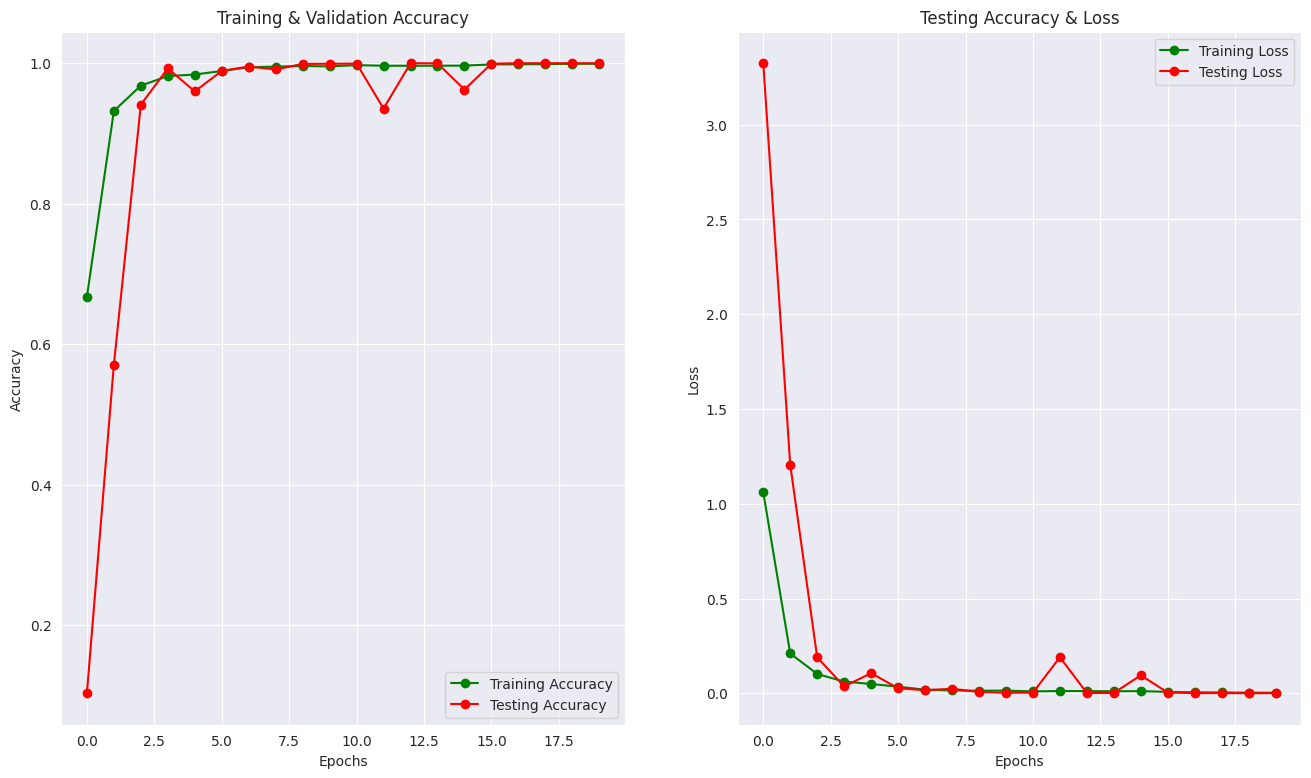

In [ ]:

epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
class_probabilities = model.predict(x_test)

# Convert class probabilities to class indices using np.argmax
predictions = np.argmax(class_probabilities, axis=1)

# Modify predictions based on the given logic
# Increment predictions with class index >= 9 by 1
predictions = np.where(predictions >= 9, predictions + 1, predictions)

# Display the first 5 modified predictions
print(predictions[:5])

225/225 [==============================] - 14s 59ms/step
[ 6  5 10  0  3]


In [ ]:

classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

In [ ]:
cm = confusion_matrix(y,predictions)


In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])


<Axes: >

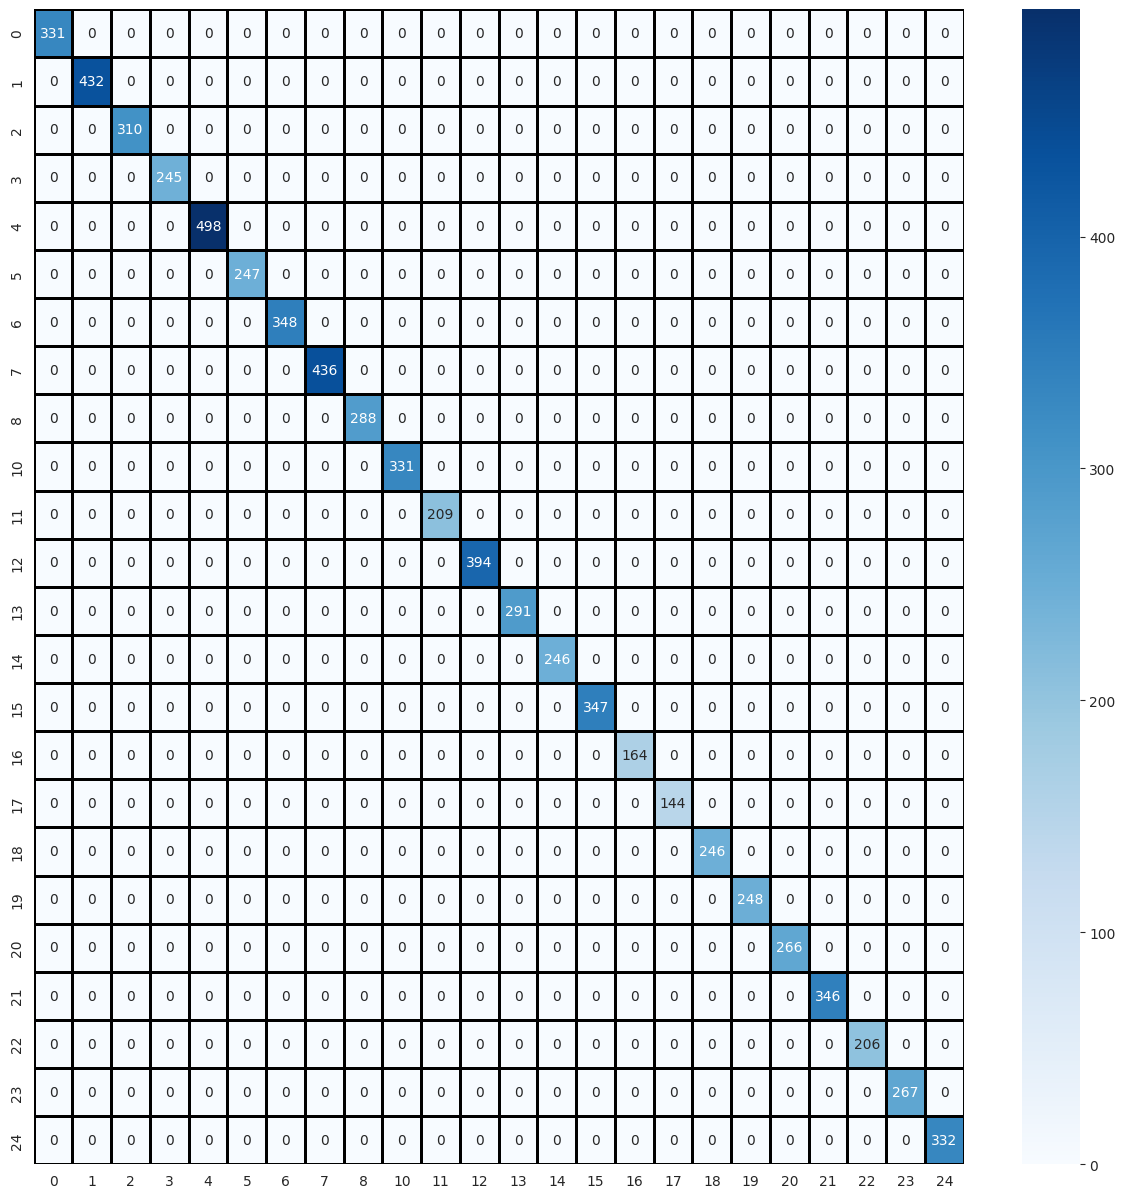

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')


In [ ]:
correct = np.nonzero(predictions == y)[0]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `x_test` is the test data, `y` is the true labels, and `predictions` is the predicted labels.

# Calculate correct predictions indices
correct_indices = np.where(predictions == y)[0]

# Define rows and cols for subplots (adjust as needed)
rows = 3
cols = 3

# Calculate the total number of subplots per figure
num_subplots = rows * cols

# Define the number of correct predictions
num_correct = len(correct_indices)

# Initialize figure
fig = plt.figure(figsize=(10, 10))

# Loop through correct predictions
for i in range(num_correct):
    # Calculate the subplot position
    subplot_position = i + 1

    # If the subplot position exceeds the total subplots per figure, show the current figure
    # and start a new figure
    if subplot_position > num_subplots:
        plt.tight_layout(pad=2)
        plt.show()
        fig = plt.figure(figsize=(10, 10))
        subplot_position = 1

    # Create a subplot for each correct prediction
    ax = fig.add_subplot(rows, cols, subplot_position)

    # Get the index of the correct prediction
    index = correct_indices[i]

    # Display the test image
    ax.imshow(x_test[index].reshape(28, 28), cmap="gray", interpolation='none')

    # Set the title with predicted and actual class labels
    ax.set_title(f"Predicted Class {predictions[index]}, Actual Class {y[index]}")

    # Remove axis ticks for cleaner display
    ax.set_xticks([])
    ax.set_yticks([])

# Show the final figure
plt.tight_layout(pad=2)
plt.show()
